In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

## Reflect Tables into SQLALchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine,reflect = True)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session=Session(engine)

## Bonus Challenge Assignment: Temperature Analysis II

In [9]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, maximum, and average temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# For example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [10]:
# Use the function `calc_temps` to calculate the tmin, tavg, and tmax 
# for a year in the data set
start_date='2016-12-24'
end_date='2017-01-01'
temp = calc_temps(start_date,end_date)

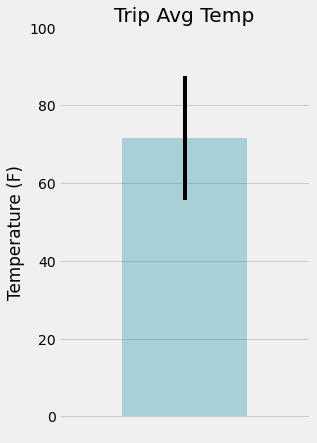

In [11]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for bar height (y value)
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
avg_temp = temp[0][1]
bar = temp[0][2]-temp[0][0]
plt.rcParams['figure.figsize']=(4,7)
plt.bar(0,avg_temp, color='xkcd:teal blue', alpha=0.3, width=0.1,align="center",yerr=bar)
plt.title('Trip Avg Temp')
plt.xticks([])
plt.ylabel('Temperature (F)')
plt.xlim(-0.1,0.1)
plt.ylim(-5,100)
plt.show()

### Daily Rainfall Average

In [12]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's 
# matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
total_prcp_by_station=session.query(Measurement.station,Station.name,func.sum(Measurement.prcp),Station.latitude,Station.longitude,Station.elevation).\
    filter(Measurement.date >= start_date).\
    filter(Measurement.date <= end_date).\
    filter(Measurement.station == Station.station).\
    group_by(Measurement.station).\
    order_by(func.sum(Measurement.prcp).desc()).all()

In [13]:
print(f'Daily total rainfall estimates by station for dates between {start_date} and {end_date}.')

total_prcp_by_station_df=pd.DataFrame(total_prcp_by_station, columns=['station','name','total_prcp','latitude','longitude','elevation'])
total_prcp_by_station_df

Daily total rainfall estimates by station for dates between 2016-12-24 and 2017-01-01.


,station,name,total_prcp,latitude,longitude,elevation
0,USC00516128,"MANOA LYON ARBO 785.2, HI US",7.55,21.33310,-157.80250,152.4
1,USC00513117,"KANEOHE 838.1, HI US",1.85,21.42340,-157.80150,14.6
2,USC00519281,"WAIHEE 837.5, HI US",1.67,21.45167,-157.84889,32.9
3,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",1.37,21.52130,-157.83740,7.0
4,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",0.30,21.33556,-157.71139,19.5
5,USC00519397,"WAIKIKI 717.2, HI US",0.22,21.27160,-157.81680,3.0
6,USC00517948,"PEARL CITY, HI US",NaN,21.39340,-157.97510,11.9


In [14]:
# Use this function to calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()

# For example
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [15]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
start_date='2016-12-24'
end_date='2017-01-01'

# Use the start and end date to create a range of dates
# Strip off the year and save a list of strings in the format %m-%d
trip_dates=['12-24','12-25','12-26','12-27','12-28','12-29','12-30','12-31','01-01']

normals=[]

# Use the `daily_normals` function to calculate the normals for each date string 
# and append the results to a list called `normals`.
for date in trip_dates:
    daily_normal = daily_normals(date)
    daily_dict = {}
    daily_dict['min_temp'] = daily_normal[0][0]
    daily_dict['avg_temp'] = daily_normal[0][1]
    daily_dict['max_temp'] = daily_normal[0][2]
    normals.append(daily_dict)
normals

[{'min_temp': 62.0, 'avg_temp': 70.0625, 'max_temp': 78.0},
 {'min_temp': 60.0, 'avg_temp': 71.75, 'max_temp': 79.0},
 {'min_temp': 63.0, 'avg_temp': 71.44680851063829, 'max_temp': 77.0},
 {'min_temp': 62.0, 'avg_temp': 71.91666666666667, 'max_temp': 79.0},
 {'min_temp': 62.0, 'avg_temp': 70.52083333333333, 'max_temp': 77.0},
 {'min_temp': 57.0, 'avg_temp': 70.29166666666667, 'max_temp': 78.0},
 {'min_temp': 63.0, 'avg_temp': 69.86363636363636, 'max_temp': 76.0},
 {'min_temp': 56.0, 'avg_temp': 68.27906976744185, 'max_temp': 77.0},
 {'min_temp': 62.0, 'avg_temp': 69.15384615384616, 'max_temp': 77.0}]

In [16]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
daily_normals_df=pd.DataFrame(normals,columns=['min_temp','avg_temp','max_temp'],index=trip_dates)
daily_normals_df.index.name='date'
daily_normals_df

,min_temp,avg_temp,max_temp
date,,,
12-24,62.0,70.062500,78.0
12-25,60.0,71.750000,79.0
12-26,63.0,71.446809,77.0
12-27,62.0,71.916667,79.0
12-28,62.0,70.520833,77.0
12-29,57.0,70.291667,78.0
12-30,63.0,69.863636,76.0
12-31,56.0,68.279070,77.0
01-01,62.0,69.153846,77.0


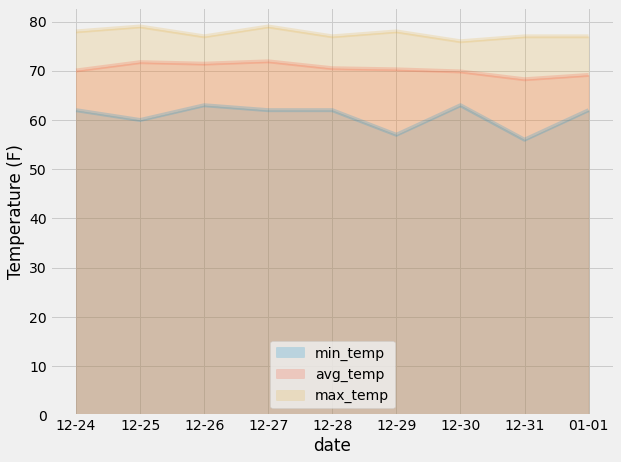

In [17]:
# Plot the daily normals as an area plot with `stacked=False`
plt.rcParams['figure.figsize']=(9,7)
daily_normals_df.plot.area(stacked = False,alpha=0.2)
plt.gca().legend(loc='lower center')
plt.ylabel('Temperature (F)')
plt.show()

## Close Session

In [18]:
session.close()